Question 1

Parameters of the largest detected circle:
Center Coordinates: (106, 256)
Circle Radius: 16
Sigma Value: 2.2777777777777777


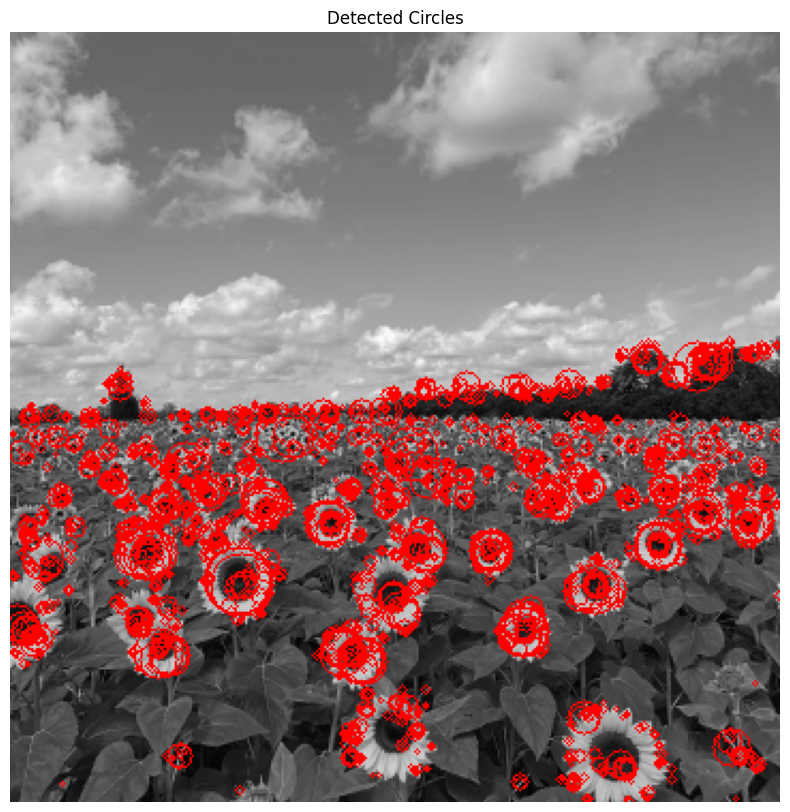

In [109]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the sunflower field image
sunflower_image = cv2.imread('the_berry_farms_sunflower_field.jpeg', cv2.IMREAD_REDUCED_COLOR_4)
gray_sunflower_image = cv2.cvtColor(sunflower_image, cv2.COLOR_BGR2GRAY)

# Set up parameters for scale-space extrema detection
min_blob_sigma = 0.5  # Minimum sigma value (smaller values for smaller blobs)
max_blob_sigma = 2.5  # Maximum sigma value (larger values for larger blobs)
num_sigma_values = 10  # Number of sigma values to test
blob_detection_threshold = 0.35  # Threshold for blob detection

# Create an empty list to store detected circles
detected_circles = []

# Loop through different sigma values to detect blobs at different scales
for blob_sigma in np.linspace(min_blob_sigma, max_blob_sigma, num_sigma_values):
    # Apply LoG (Laplacian of Gaussian) to the grayscale image with the current sigma
    blurred_sunflower_image = cv2.GaussianBlur(gray_sunflower_image, (0, 0), blob_sigma)
    laplacian_sunflower = cv2.Laplacian(blurred_sunflower_image, cv2.CV_64F)

    # Calculate the absolute Laplacian values
    abs_laplacian_sunflower = np.abs(laplacian_sunflower)

    # Create a binary image where blobs are detected using the threshold
    blob_mask = abs_laplacian_sunflower > blob_detection_threshold * abs_laplacian_sunflower.max()

    # Find contours in the blob mask
    contours, _ = cv2.findContours(blob_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Loop through the detected contours and fit circles to them
    for contour in contours:
        if len(contour) >= 5:
            (x, y), radius = cv2.minEnclosingCircle(contour)
            center = (int(x), int(y))
            radius = int(radius)
            detected_circles.append((center, radius, blob_sigma))

# Sort the detected circles by radius in descending order
detected_circles.sort(key=lambda x: -x[1])

# Report the parameters of the largest circle
largest_detected_circle = detected_circles[0]
center_coordinates, circle_radius, circle_sigma = largest_detected_circle

print("Parameters of the largest detected circle:")
print(f"Center Coordinates: {center_coordinates}")
print(f"Circle Radius: {circle_radius}")
print(f"Sigma Value: {circle_sigma}")

# Set the desired line thickness for drawn circles
line_thickness = 1

# Draw all detected circles with the specified line thickness
output_image_with_circles = cv2.cvtColor(gray_sunflower_image, cv2.COLOR_GRAY2BGR)
for circle_info in detected_circles:
    circle_center, circle_radius, _ = circle_info
    cv2.circle(output_image_with_circles, circle_center, circle_radius, (0, 0, 255), line_thickness)  # Red color

# Display the grayscale image with detected circles using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image_with_circles, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off')
plt.title('Detected Circles')
plt.show()


Question 2

Number of inliers in the line: 16
Parameters of the estimated line:
a: 0.7080986693010423
b: 0.7061134997534697
d: 1.5303717301982513
Number of remnant points: 84
Number of inliers in the circle: 16
Parameters of the estimated circle:
x_center: 2.0388812056906938
y_center: 2.905374551155992
radius: 9.971739443086292


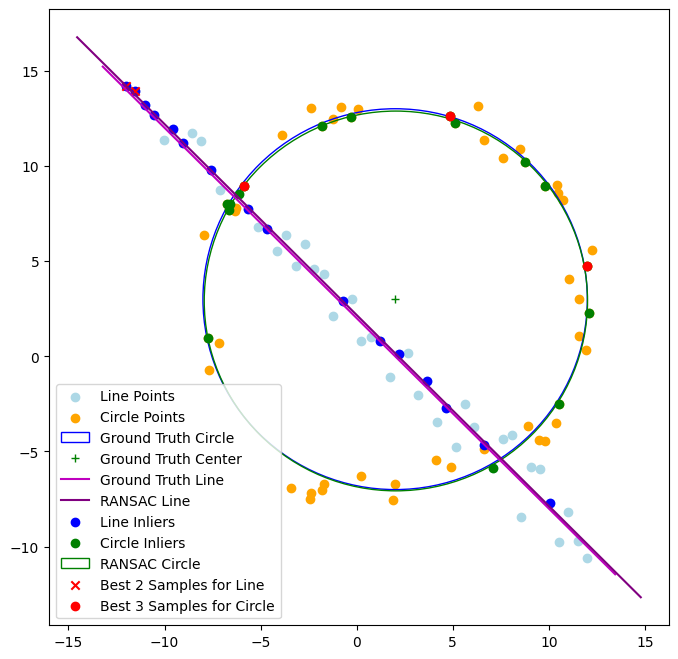

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Seed for reproducibility
np.random.seed(1)

# Parameters
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Ground truth center of the circle
noise_scale = r / 16

# Generate points for the circle
theta = np.random.uniform(0, 2 * np.pi, half_n)
noise = noise_scale * np.random.randn(half_n)
x_circle = x0_gt + (r + noise) * np.cos(theta)
y_circle = y0_gt + (r + noise) * np.sin(theta)

points_circle = np.column_stack((x_circle, y_circle))

# Generate points for the line
line_scale = 1.0
slope, intercept = -1, 2

x_line = np.linspace(-12, 12, half_n)
y_line = slope * x_line + intercept + line_scale * np.random.randn(half_n)

points_line = np.column_stack((x_line, y_line))

# Concatenate points from both circle and line
all_points = np.vstack((points_circle, points_line))

# Plot the noisy points, ground truth line, and ground truth circle
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(points_line[:, 0], points_line[:, 1], color='lightblue', label='Line Points')
ax.scatter(points_circle[:, 0], points_circle[:, 1], color='orange', label='Circle Points')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='blue', fill=False, label='Ground Truth Circle')
ax.add_artist(circle_gt)
ax.plot(x0_gt, y0_gt, '+g', label='Ground Truth Center')
x_range = np.linspace(*ax.get_xlim(), 100)
y_range = slope * x_range + intercept
plt.plot(x_range, y_range, color='m', label='Ground Truth Line')

# Define a function to calculate the line equation from two points
def line_equation_from_points(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = (a * x1) + (b * y1)
    return a, b, d

# RANSAC to fit a line with unit normal constraint
def ransac_line(points, iterations, threshold, min_inliers):
    best_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(points), 2, replace=False)
        x1, y1 = points[sample_indices[0]]
        x2, y2 = points[sample_indices[1]]
        
        a, b, d = line_equation_from_points(x1, y1, x2, y2)
        
        # Constraint: Ensure unit normal vector
        magnitude = np.sqrt(a**2 + b**2)
        a /= magnitude
        b /= magnitude
        
        # Calculate the distance of all points to the line
        distances = np.abs(a * points[:, 0] + b * points[:, 1] - d)
        
        # Find inliers based on the threshold
        inliers = np.where(distances < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (a, b, d)
                best_inliers = inliers
                
    return best_model, best_inliers

# RANSAC parameters for line estimation
line_iterations = 10000
line_threshold = 0.15
line_min_inliers = 15

# Estimate the line using RANSAC
best_line_model, line_inlier_indices = ransac_line(points_line, line_iterations, line_threshold, line_min_inliers)

# Print results
print("Number of inliers in the line:", len(line_inlier_indices))
print("Parameters of the estimated line:")
print(f"a: {best_line_model[0]}")
print(f"b: {best_line_model[1]}")
print(f"d: {best_line_model[2]}")

# Define a function to calculate the circle equation from three points
def circle_equation_from_points(x1, y1, x2, y2, x3, y3):
    mx1, my1 = (x1 + x2) / 2, (y1 + y2) / 2
    mx2, my2 = (x2 + x3) / 2, (y2 + y3) / 2
    
    if y2 - y1 == 0:
        slope1 = 0
    else:
        slope1 = (x2 - x1) / (y2 - y1)
    
    if y3 - y2 == 0:
        slope2 = 0
    else:
        slope2 = (x3 - x2) / (y3 - y2)
    
    x_center = (slope1 * mx1 - slope2 * mx2 + my2 - my1) / (slope1 - slope2)
    y_center = -slope1 * (x_center - mx1) + my1
    
    radius = np.sqrt((x1 - x_center)**2 + (y1 - y_center)**2)
    
    return x_center, y_center, radius

# RANSAC to fit a circle
def ransac_circle(points, iterations, threshold, min_inliers):
    best_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(points), 3, replace=False)
        x1, y1 = points[sample_indices[0]]
        x2, y2 = points[sample_indices[1]]
        x3, y3 = points[sample_indices[2]]
        
        x_center, y_center, radius = circle_equation_from_points(x1, y1, x2, y2, x3, y3)
        
        errors = np.abs(np.sqrt((points[:, 0] - x_center)**2 + (points[:, 1] - y_center)**2) - radius)
        
        inliers = np.where(errors < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (x_center, y_center, radius)
                best_inliers = inliers
                
    return best_model, best_inliers

# RANSAC parameters for circle estimation
circle_iterations = 10000
circle_threshold = 0.2
circle_min_inliers = 15

# Identify remnant points (not explained by the line)
remnant_indices = [i for i in range(len(all_points)) if i not in line_inlier_indices]
remnant_points = all_points[remnant_indices]

# Print the number of remnant points
print("Number of remnant points:", len(remnant_points))

# Estimate the circle using RANSAC
best_circle_model, circle_inlier_indices = ransac_circle(remnant_points, circle_iterations, circle_threshold, circle_min_inliers)

# Print results
print("Number of inliers in the circle:", len(circle_inlier_indices))
print("Parameters of the estimated circle:")
print(f"x_center: {best_circle_model[0]}")
print(f"y_center: {best_circle_model[1]}")
print(f"radius: {best_circle_model[2]}")

# Plot the results

# Plot the estimated line
x_range = np.linspace(*ax.get_xlim(), 100)
y_range = (-best_line_model[0] * x_range + best_line_model[2]) / best_line_model[1]
plt.plot(x_range, y_range, label='RANSAC Line', color='purple')

ax.scatter(points_line[line_inlier_indices, 0], points_line[line_inlier_indices, 1], color='blue', label='Line Inliers')

# Find the best 2 samples for the line
best_line_sample_indices = line_inlier_indices[:2]
best_line_samples = points_line[best_line_sample_indices]

# Plot the inliers of the circle
ax.scatter(remnant_points[circle_inlier_indices, 0], remnant_points[circle_inlier_indices, 1], color='g', label='Circle Inliers')

# Plot the estimated circle
x_center, y_center, radius = best_circle_model
circle_estimated = plt.Circle((x_center, y_center), radius, color='g', fill=False, label='RANSAC Circle')
ax.add_artist(circle_estimated)

# Find the best 3 samples for the circle (using circle_inlier_indices)
best_circle_sample_indices = circle_inlier_indices[:3]
best_circle_samples = remnant_points[best_circle_sample_indices]

# Plot the best 2 samples for the line and the best 3 samples for the circle
ax.scatter(best_line_samples[:, 0], best_line_samples[:, 1], color='red', marker='x', label='Best 2 Samples for Line')
ax.scatter(best_circle_samples[:, 0], best_circle_samples[:, 1], color='red', marker='o', label='Best 3 Samples for Circle')

plt.legend()
plt.show()


Question 3

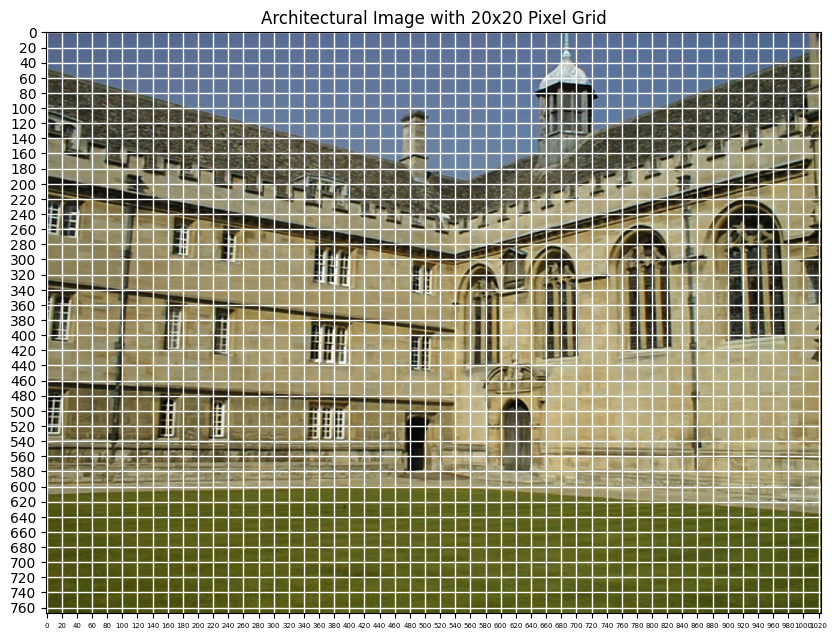

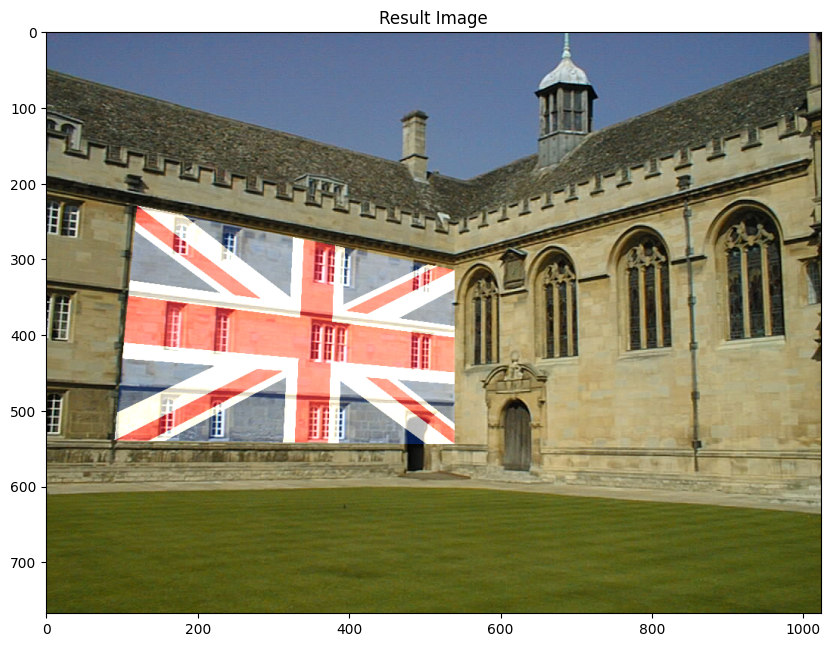

In [81]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
architectural_im = cv2.imread('architecture.jpg')
flag_im = cv2.imread('flag.png')

# Display the architectural image with a 20x20 pixel grid
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(architectural_im, cv2.COLOR_BGR2RGB))
plt.xticks(np.arange(0, architectural_im.shape[1], 20), fontsize=5)
plt.yticks(np.arange(0, architectural_im.shape[0], 20))
plt.grid(True, color='white', linewidth=1)
plt.title('Architectural Image with 20x20 Pixel Grid')
plt.show()

# Define corresponding points for homography
architecture_points = np.array([[120, 230], [540, 315], [540, 545], [90, 540]], dtype=np.float32)
flag_points = np.array([[0, 0], [flag_im.shape[1], 0], [flag_im.shape[1], flag_im.shape[0]], [0, flag_im.shape[0]]], dtype=np.float32)

# Compute homography matrix
homography_matrix, _ = cv2.findHomography(flag_points, architecture_points)

# Warp the flag image onto the architectural image
flag_warped = cv2.warpPerspective(flag_im, homography_matrix, (architectural_im.shape[1], architectural_im.shape[0]))

# Blend images
result_image = cv2.addWeighted(architectural_im, 1, flag_warped, 0.7, 0)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Result Image')
plt.show()


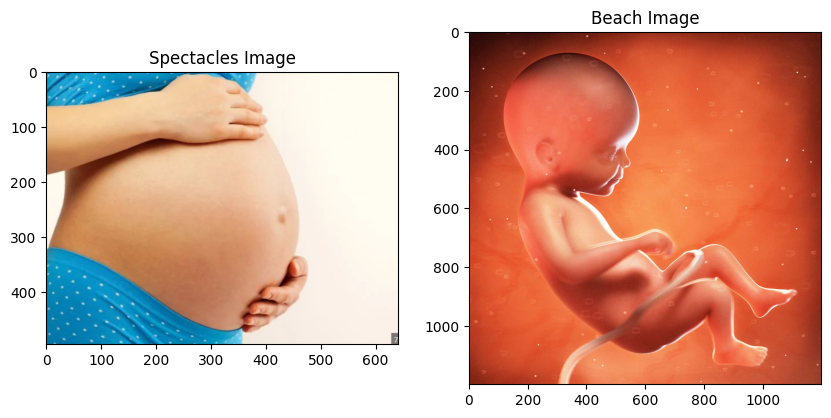

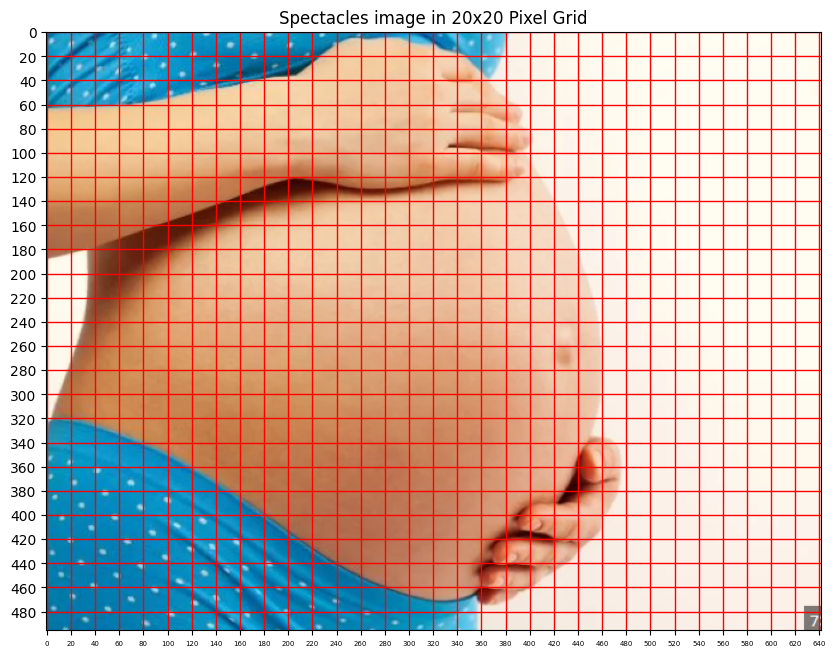

In [84]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the monitor image and the wallpaper image
woman_im = cv2.imread('belly.png')
baby_im = cv2.imread('baby.jpg')

# Display two images side-by-side
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(woman_im, cv2.COLOR_BGR2RGB))
plt.title('Spectacles Image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(baby_im, cv2.COLOR_BGR2RGB))
plt.title('Beach Image')
plt.show()

# Display the monitor image with a 20x20 pixel grid
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(woman_im, cv2.COLOR_BGR2RGB))
plt.xticks(np.arange(0, woman_im.shape[1], 20), fontsize=5)
plt.yticks(np.arange(0, woman_im.shape[0], 20))
plt.grid(True, color='red', linewidth=1)
plt.title('Spectacles image in 20x20 Pixel Grid')
plt.show()


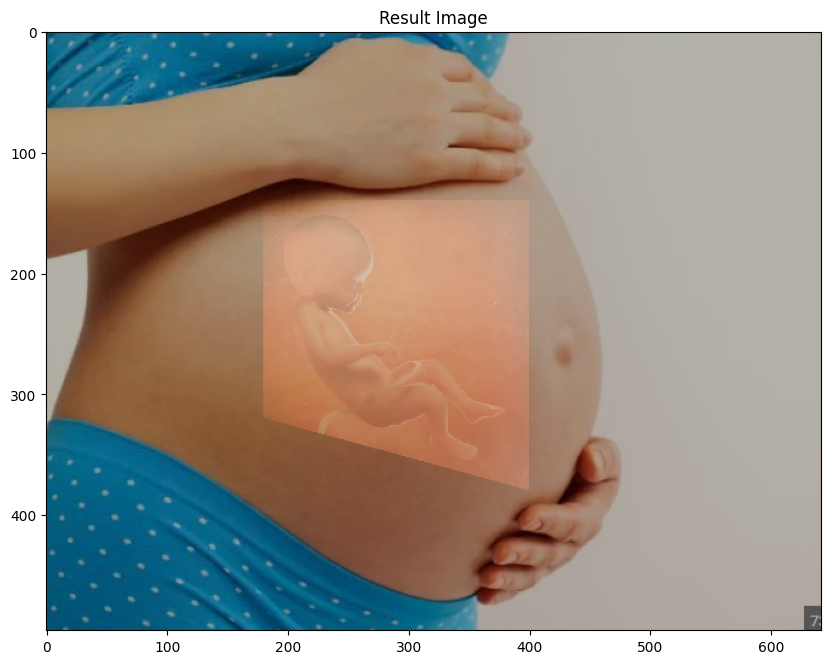

In [96]:
# Define the four points on the monitor image that form a planar surface
# Replace these with the actual coordinates
#points_on_woman = np.array([[140, 180],  [140, 400], [380, 400],[320, 180]], dtype=np.float32)

points_on_woman = np.array([[180,140],  [400,140], [400,380],[180,320]], dtype=np.float32)

# Define the corresponding points on the wallpaper image (in the same order)
points_on_baby = np.array([[0, 0], [baby_im.shape[1], 0], [baby_im.shape[1], baby_im.shape[0]], [0, baby_im.shape[0]]], dtype=np.float32)

# Compute the homography matrix
homography_matrix, _ = cv2.findHomography(points_on_baby, points_on_woman)

# Warp the wallpaper image onto the monitor image using the homography
warped_im = cv2.warpPerspective(baby_im, homography_matrix, (woman_im.shape[1], woman_im.shape[0]))

# Blend the warped wallpaper image with the monitor image
result_image = cv2.addWeighted(woman_im, 0.7, warped_im, 0.2, 0)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Result Image')
plt.show()

Question 4


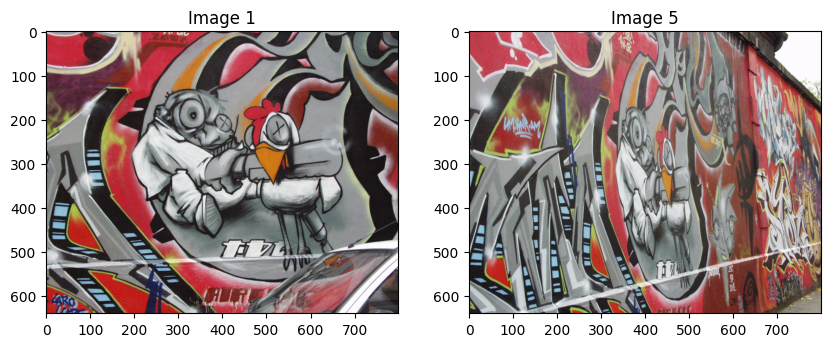

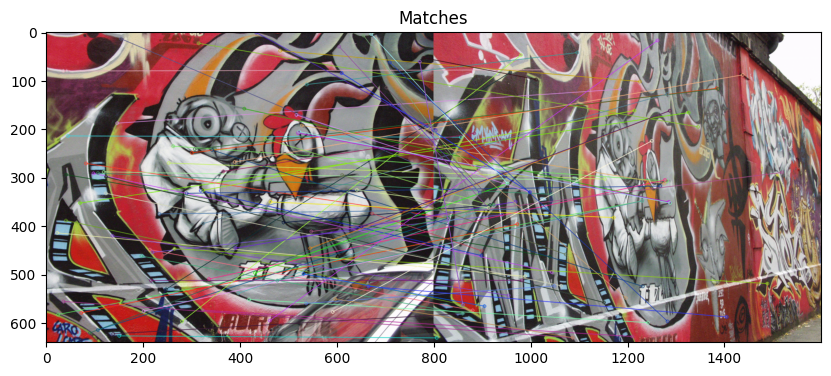

In [101]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
image1 = cv2.imread('img1.ppm', cv2.IMREAD_ANYCOLOR)
image5 = cv2.imread('img5.ppm', cv2.IMREAD_ANYCOLOR)

# Plot the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Image 1')
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Image 5')
plt.imshow(cv2.cvtColor(image5, cv2.COLOR_BGR2RGB))
plt.show()

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find keypoints and descriptors in both images
keypoints_image1, descriptors_image1 = sift.detectAndCompute(image1, None)
keypoints_image5, descriptors_image5 = sift.detectAndCompute(image5, None)

# Create a brute-force matcher
brute_force_matcher = cv2.BFMatcher()

# Match descriptors
matches = brute_force_matcher.knnMatch(descriptors_image1, descriptors_image5, k=2)

# Apply Lowe's ratio test to filter good matches
good_matches = []
points_image1 = []
points_image5 = []
for match, nearest_match in matches:
    if match.distance < 0.75 * nearest_match.distance:
        good_matches.append(match)
        points_image1.append(keypoints_image1[match.queryIdx].pt)
        points_image5.append(keypoints_image5[match.trainIdx].pt)

# Draw the matches
matched_image = cv2.drawMatches(image1, keypoints_image1, image5, keypoints_image5, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Save the image with matches
cv2.imwrite('matches.jpg', matched_image)

# Change the image to RGB color space
# matched_image_rgb = cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB)

# Plot the image with matches
plt.figure(figsize=(10, 10))
plt.title('Matches')
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.show()


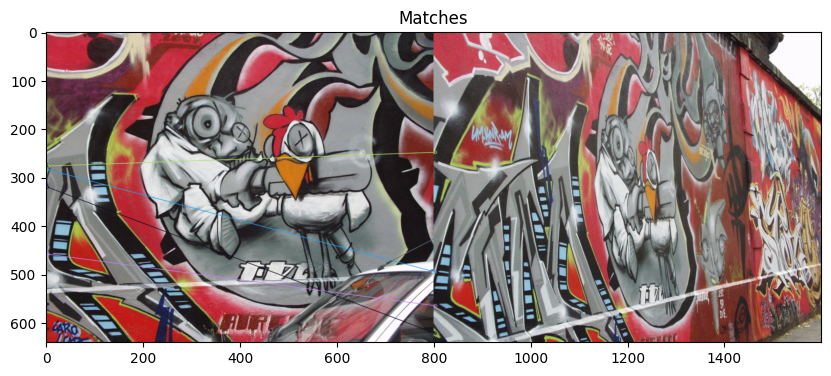

Homography Matrix:
[[-2.71903675e-01 -4.16950805e-01  3.91454837e+02]
 [-7.37455530e-02  5.10715396e-02  5.88006050e+01]
 [-7.99035306e-04 -9.70054352e-04  1.00000000e+00]]
 
Original Homography Matrix:
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]


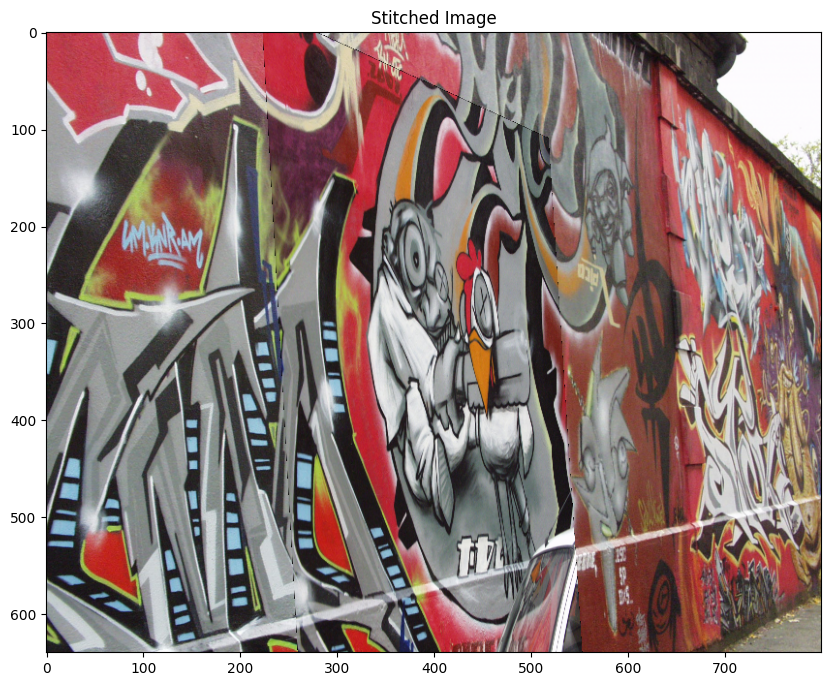

In [108]:

import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

def ransac_matching(img1, img2, num_iterations=1000, max_distance=10, min_inliers=100):
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors in both images
    keypoints_img1, descriptors_img1 = sift.detectAndCompute(img1, None)
    keypoints_img2, descriptors_img2 = sift.detectAndCompute(img2, None)

    # Create a brute-force matcher
    brute_force_matcher = cv2.BFMatcher()

    best_matches = []  # Store the best matches found by RANSAC
    best_homography = None  # Store the best homography matrix
    best_inliers = []  # Store the inliers of the best model

    for _ in range(num_iterations):
        # Randomly select four matches
        random_matches = random.sample(range(len(keypoints_img1)), 4)

        # Get the keypoints for the selected matches
        src_pts = np.float32([keypoints_img1[m].pt for m in random_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_img2[m].pt for m in random_matches]).reshape(-1, 1, 2)
        
        # Compute the homography matrix
        homography, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, max_distance)

        # Transform keypoints from img1 to img2 using the computed homography
        transformed_pts = cv2.perspectiveTransform(src_pts, homography)

        # Calculate the Euclidean distances between transformed and actual keypoints in img2
        distances = np.sqrt(np.sum((dst_pts - transformed_pts) ** 2, axis=2))

        # Count the number of inliers (matches within a certain distance threshold)
        inliers = np.count_nonzero(distances < max_distance)

        # Update if this model has more inliers than the current best
        if inliers > len(best_inliers):
            best_inliers = distances < max_distance
            best_matches = random_matches
            best_homography = homography

        # If we have enough inliers, exit early
        if inliers >= min_inliers:
            break

    # Filter the best matches using inliers
    filtered_matches = [cv2.DMatch(i, i, 0) for i, is_inlier in enumerate(best_inliers) if is_inlier]

    return filtered_matches, best_homography, keypoints_img1, keypoints_img2

# Find matching points using custom RANSAC
matches, homography, keypoints_img1, keypoints_img2 = ransac_matching(image1, image5)

# Draw the matching points
matched_img = cv2.drawMatches(image1, keypoints_img1, image5, keypoints_img2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Show the image with matches
plt.figure(figsize=(10, 10))
plt.title('Matches')
plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
plt.show()

print("Homography Matrix:")
print(homography)

print(" ")

# Load homography matrix from file
homography_from_file = np.loadtxt("H1to5p")

# Print the original homography matrix
print("Original Homography Matrix:")
print(homography_from_file)

# Warp img1 onto img5 using the homography
img1_warped = cv2.warpPerspective(image1, homography_from_file, (image5.shape[1], image5.shape[0]))

# Create a binary mask of the warped image
_, img1_mask = cv2.threshold(cv2.cvtColor(img1_warped, cv2.COLOR_BGR2GRAY), 1, 255, cv2.THRESH_BINARY)

# Invert the mask to get the region where img1 should be placed
img5_mask = cv2.bitwise_not(img1_mask)

# Blend the two images together
result = cv2.bitwise_and(image5, image5, mask=img5_mask)
result = cv2.add(result, img1_warped)

# Display the stitched image
plt.figure(figsize=(10, 10))
plt.title('Stitched Image')
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()
